# T7. COLUMNS RECONSTRUCTION

    T7.1 RECTANGULAR COLUMNS 

In this script, we reconstruct columns from the instance segmentation and reference heights.
We need:
 - T0 for classes and objects
 - T1: objest and objects_ids
 - T5: reference levels

## LIBRARIES

In [2]:
#IMPORT PACKAGES
from rdflib import Graph
import os.path
from pathlib import Path
import numpy as np
import laspy
from scipy.spatial import ConvexHull

from geomapi.nodes import *
from geomapi.utils import geometryutils as gmu
import geomapi.tools as tl

from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /tmp/matplotlib-a1lsglbn because the default path (/home/rha/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## INPUTS & OUTPUTS DEFINITION

In [3]:
name = '19_MedOffice_07_F4_labels'

path = Path(os.getcwd()).parents[2]
input_folder = path/'test_data'/'19_MedOffice_07_F4'
print('Input folder: ', input_folder)

output_folder = path/'test_data'/'19_MedOffice_07_F4'
print('Output path: ', output_folder)

output_file_path = os.path.join(output_folder, f'{name}_output_columns.txt') 

Input folder:  /home/rha/roberto/projects/Scan-to-BIM-CVPR-2024/test_data/19_MedOffice_07_F4
Output path:  /home/rha/roberto/projects/Scan-to-BIM-CVPR-2024/test_data/19_MedOffice_07_F4


## DATA LOAD

Loading graph and point cloud (.laz)

In [5]:
graphPath = str(path/'test_data'/'19_MedOffice_07_F4'/f'{name}_graph.ttl')
graph = Graph().parse(graphPath)

nodes = tl.graph_to_nodes(graph)
columnNodes = [n for n in nodes if 'Columns' in n.subject and type(n)==PointCloudNode]

print(f'{len(columnNodes)} columnNodes detected!')

file_name = input_folder/'3_Columns.laz'
laz  = laspy.read(file_name)

pcd = gmu.las_to_pcd(laz)
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()
pcdNodes = PointCloudNode(resource=pcd)

# Read point cloud
laz = laspy.read(file_name)

# Dictionaries
columns_points = {}
columns_points_2d = {}

for i, node in enumerate(columnNodes):

    idx = np.where((laz['classes'] == node.class_id) & (laz['objects'] == node.object_id))
    
    if len(idx[0]) > 0:

        columns_points[node.object_id] = np.vstack((laz.x[idx], laz.y[idx], laz.z[idx], np.asarray(pcd.normals)[idx, 0], np.asarray(pcd.normals)[idx, 1], np.asarray(pcd.normals)[idx, 2])).transpose() 

        avg_z = np.mean(laz.z[idx])

        # Place points at avg_z
        columns_points_2d[node.object_id] = np.vstack((laz.x[idx], laz.y[idx], np.full_like(laz.z[idx], avg_z), np.asarray(pcd.normals)[idx, 0], np.asarray(pcd.normals)[idx, 1], np.asarray(pcd.normals)[idx, 2])).transpose() 

15 columnNodes detected!


## COLUMNS FEATURES COMPUTATION

### UTILS FUNCTIONS

In [6]:
def compute_bounding_box(points):
    
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([np.cos(angles), np.cos(angles-pi2), np.cos(angles+pi2),np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # Covariance matrix
    cov = np.cov(points, rowvar=False)

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval, r


def column_featrues(points, bbox, rotation_matrix):
    
    centre_r = np.mean(bbox, axis = 0)
    centre = np.append(centre_r, 0)

    # Vertices
    A = bbox[0]
    B = bbox[1]
    C = bbox[2]
    D = bbox[3]

    # Dimensions
    horizontal_segment = (D[0]-B[0], D[1]-B[1])
    width = np.sqrt(horizontal_segment[0]**2 + horizontal_segment[1]**2)
    vertical_segment = (A[0]-C[0], A[1]-C[1])
    depth = np.sqrt(vertical_segment[0]**2 + vertical_segment[1]**2)
    # Rotation
    angle = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
    rotation = np.degrees(angle)    
    
    z_values = points[:, 2]
    min_z = np.min(z_values)
    max_z = np.max(z_values)
    heigth = max_z - min_z
    
    return width, depth, heigth, centre, rotation


def rotate_points(points, center, rotation_matrix):

        rotated_points = []

        for point in points: 
            shifted = point - center   
            rotated = np.dot(shifted, rotation_matrix)
            rotated_points.append(rotated + center)
        rotated_points = np.array(rotated_points)

        return rotated_points

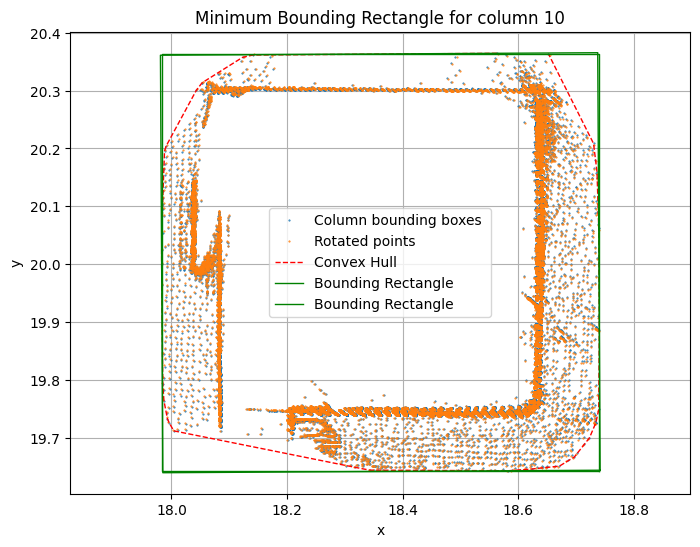

{'AB': (array([18.73937856, 19.64138465]), array([17.98304234, 19.64138465])), 'BC': (array([17.98304234, 19.64138465]), array([17.98304234, 20.36348143])), 'CD': (array([17.98304234, 20.36348143]), array([18.73937856, 20.36348143])), 'DA': (array([18.73937856, 20.36348143]), array([18.73937856, 19.64138465]))}
Middle points of each segment (in a list):
Segment name: AB, Point name: (18.361210452536, 19.641384647690792), Middle points: (18.361210452536, 19.641384647690792)
Segment name: BC, Point name: (17.983042340944564, 20.00243303878559), Middle points: (17.983042340944564, 20.00243303878559)
Segment name: CD, Point name: (18.361210452536, 20.36348142988038), Middle points: (18.361210452536, 20.36348142988038)
Segment name: DA, Point name: (18.73937856412744, 20.002433038785583), Middle points: (18.73937856412744, 20.002433038785583)
Coordinates assigned to points A1, B1, C1, D1:
A1: (18.361210452536, 19.641384647690792)
B1: (17.983042340944564, 20.00243303878559)
C1: (18.361210452

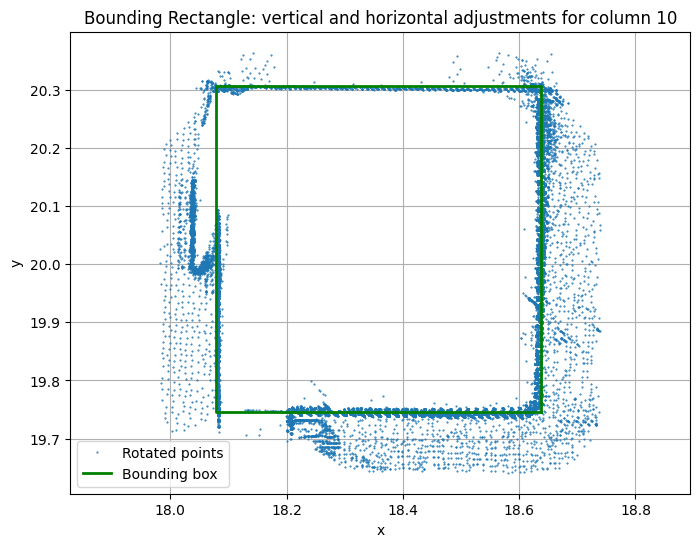

BBox_: [[18.63804234 19.74638465]
 [18.07804234 19.74638465]
 [18.07804234 20.30638465]
 [18.63804234 20.30638465]]
Center: [18.36121045 20.00243304]
BBox:  [[18.63950093 19.7479707 ]
 [18.07951007 19.74477075]
 [18.07631013 20.30476161]
 [18.63630098 20.30796156]]


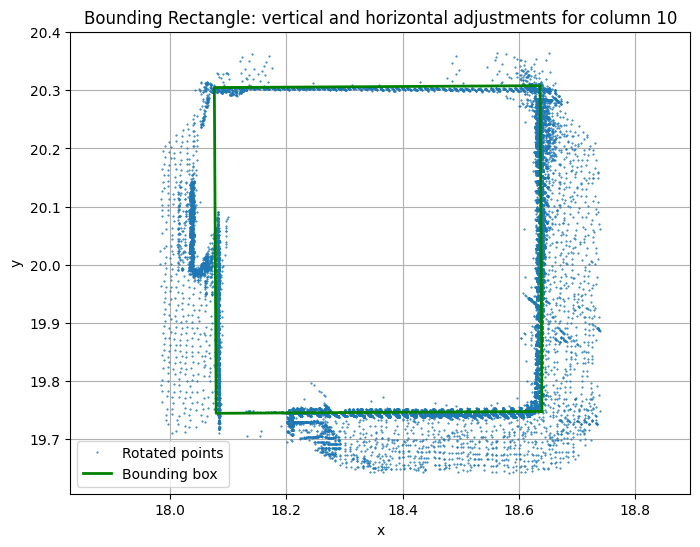

Column: 10, Width: 0.7919595949290569 Depth: 0.7919595949290569 Heigth: 2.757999999999999 loc: [18.35790553 20.02636615  0.        ] rotation -0.3274008908459504


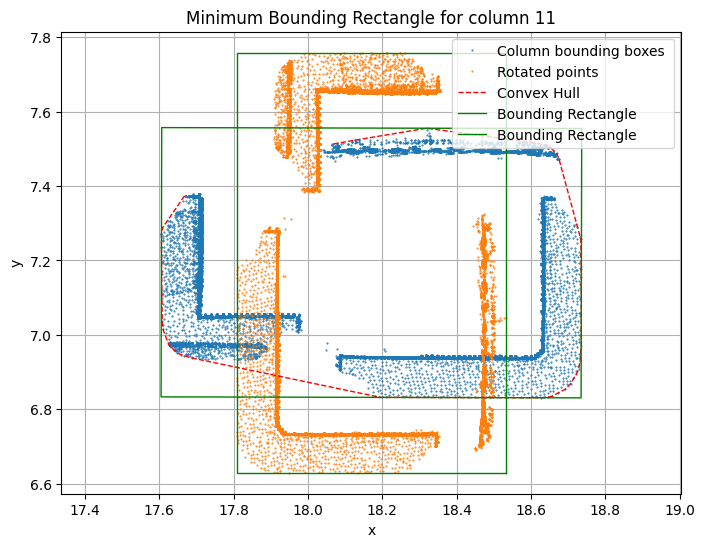

{'AB': (array([18.53285694,  6.62899864]), array([17.80857724,  6.62899864])), 'BC': (array([17.80857724,  6.62899864]), array([17.80857724,  7.7587021 ])), 'CD': (array([17.80857724,  7.7587021 ]), array([18.53285694,  7.7587021 ])), 'DA': (array([18.53285694,  7.7587021 ]), array([18.53285694,  6.62899864]))}
Middle points of each segment (in a list):
Segment name: AB, Point name: (18.170717088944006, 6.628998635945431), Middle points: (18.170717088944006, 6.628998635945431)
Segment name: BC, Point name: (17.808577241634577, 7.19385036606139), Middle points: (17.808577241634577, 7.19385036606139)
Segment name: CD, Point name: (18.170717088944006, 7.758702096177348), Middle points: (18.170717088944006, 7.758702096177348)
Segment name: DA, Point name: (18.532856936253435, 7.193850366061389), Middle points: (18.532856936253435, 7.193850366061389)
Coordinates assigned to points A1, B1, C1, D1:
A1: (18.170717088944006, 6.628998635945431)
B1: (17.808577241634577, 7.19385036606139)
C1: (18.

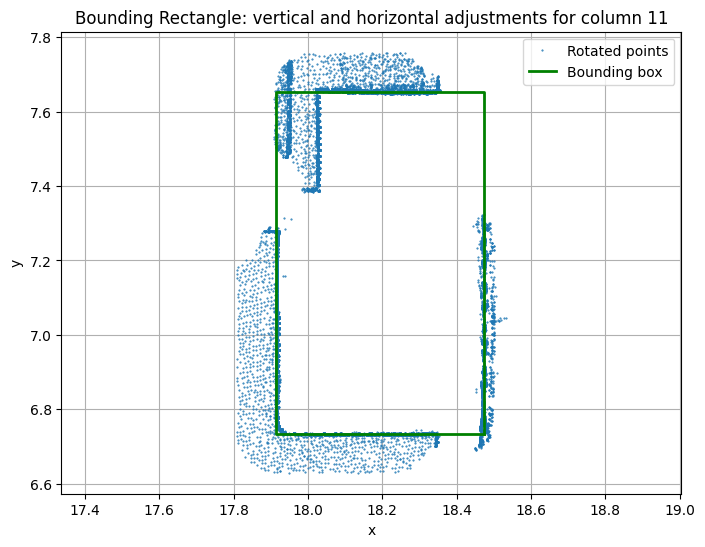

BBox_: [[18.47357724  6.73399864]
 [17.91357724  6.73399864]
 [17.91357724  7.65399864]
 [18.47357724  7.65399864]]
Center: [18.17071709  7.19385037]
BBox:  [[18.63127849  7.49563022]
 [18.62996394  6.93563177]
 [17.70996647  6.93779138]
 [17.71128102  7.49778984]]


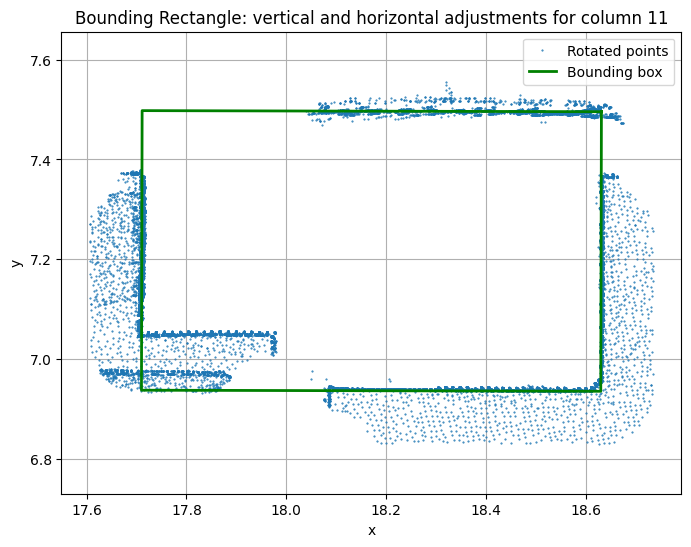

Column: 11, Width: 1.0770329614269298 Depth: 1.0770329614269314 Heigth: 2.598 loc: [18.17062248  7.2167108   0.        ] rotation -89.86550311203504


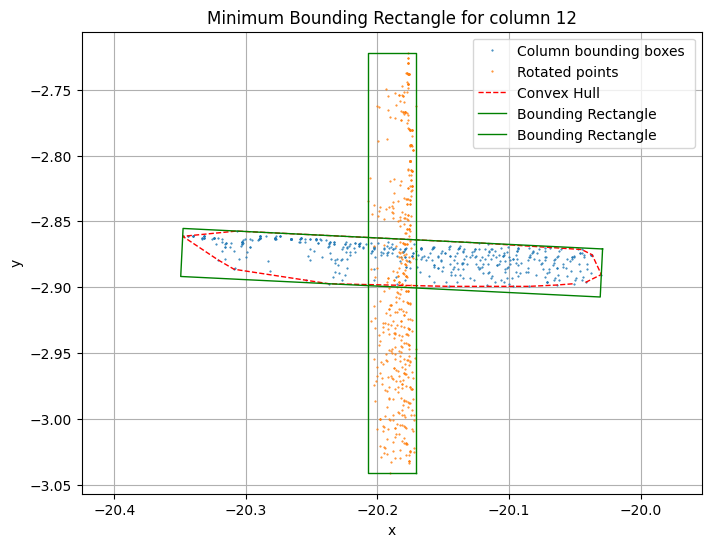

{'AB': (array([-20.17095868,  -3.04092437]), array([-20.20749109,  -3.04092437])), 'BC': (array([-20.20749109,  -3.04092437]), array([-20.20749109,  -2.72188731])), 'CD': (array([-20.20749109,  -2.72188731]), array([-20.17095868,  -2.72188731])), 'DA': (array([-20.17095868,  -2.72188731]), array([-20.17095868,  -3.04092437]))}
Middle points of each segment (in a list):
Segment name: AB, Point name: (-20.189224887901755, -3.040924370052183), Middle points: (-20.189224887901755, -3.040924370052183)
Segment name: BC, Point name: (-20.207491093614752, -2.881405839833774), Middle points: (-20.207491093614752, -2.881405839833774)
Segment name: CD, Point name: (-20.18922488790176, -2.721887309615365), Middle points: (-20.18922488790176, -2.721887309615365)
Segment name: DA, Point name: (-20.17095868218876, -2.881405839833774), Middle points: (-20.17095868218876, -2.881405839833774)
Coordinates assigned to points A1, B1, C1, D1:
A1: (-20.189224887901755, -3.040924370052183)
B1: (-20.2074910936

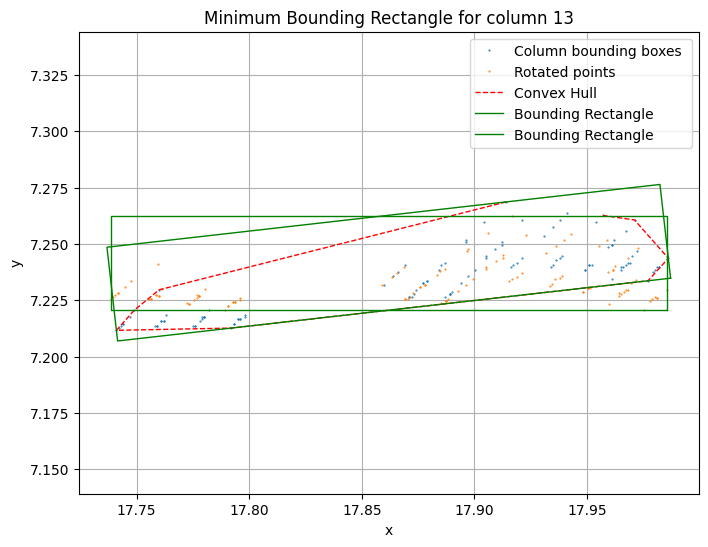

{'AB': (array([17.98547888,  7.22071083]), array([17.73843298,  7.22071083])), 'BC': (array([17.73843298,  7.22071083]), array([17.73843298,  7.26259321])), 'CD': (array([17.73843298,  7.26259321]), array([17.98547888,  7.26259321])), 'DA': (array([17.98547888,  7.26259321]), array([17.98547888,  7.22071083]))}
Middle points of each segment (in a list):
Segment name: AB, Point name: (17.861955931211433, 7.220710833439192), Middle points: (17.861955931211433, 7.220710833439192)
Segment name: BC, Point name: (17.738432984005613, 7.24165202400186), Middle points: (17.738432984005613, 7.24165202400186)
Segment name: CD, Point name: (17.861955931211437, 7.262593214564528), Middle points: (17.861955931211437, 7.262593214564528)
Segment name: DA, Point name: (17.98547887841726, 7.24165202400186), Middle points: (17.98547887841726, 7.24165202400186)
Coordinates assigned to points A1, B1, C1, D1:
A1: (17.861955931211433, 7.220710833439192)
B1: (17.738432984005613, 7.24165202400186)
C1: (17.8619

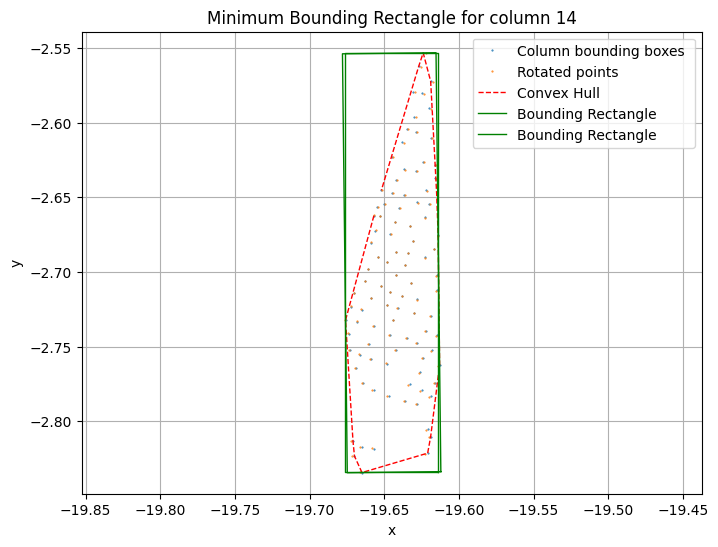

{'AB': (array([-19.61374294,  -2.8341215 ]), array([-19.67639397,  -2.8341215 ])), 'BC': (array([-19.67639397,  -2.8341215 ]), array([-19.67639397,  -2.55361129])), 'CD': (array([-19.67639397,  -2.55361129]), array([-19.61374294,  -2.55361129])), 'DA': (array([-19.61374294,  -2.55361129]), array([-19.61374294,  -2.8341215 ]))}
Middle points of each segment (in a list):
Segment name: AB, Point name: (-19.645068452381654, -2.8341214975699986), Middle points: (-19.645068452381654, -2.8341214975699986)
Segment name: BC, Point name: (-19.676393969326934, -2.693866394549176), Middle points: (-19.676393969326934, -2.693866394549176)
Segment name: CD, Point name: (-19.645068452381654, -2.553611291528353), Middle points: (-19.645068452381654, -2.553611291528353)
Segment name: DA, Point name: (-19.613742935436374, -2.693866394549176), Middle points: (-19.613742935436374, -2.693866394549176)
Coordinates assigned to points A1, B1, C1, D1:
A1: (-19.645068452381654, -2.8341214975699986)
B1: (-19.676

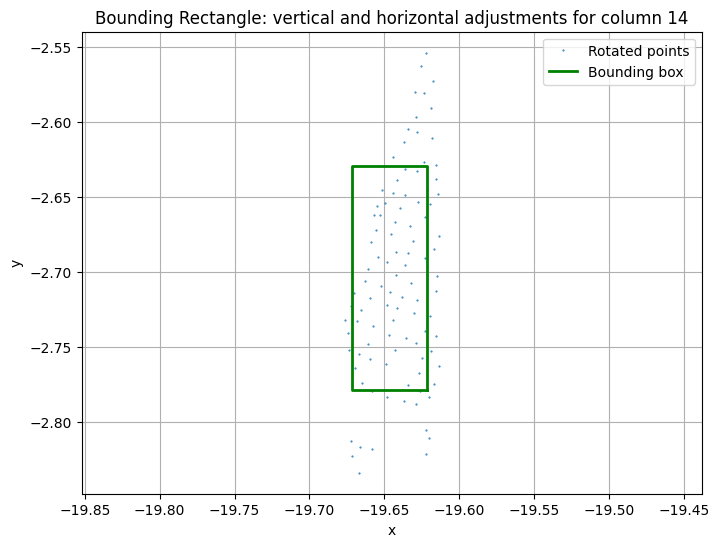

BBox_: [[-19.62139397  -2.7791215 ]
 [-19.67139397  -2.7791215 ]
 [-19.67139397  -2.6291215 ]
 [-19.62139397  -2.6291215 ]]
Center: [-19.64506845  -2.69386639]
BBox:  [[-19.62041565  -2.77884376]
 [-19.67041235  -2.77941844]
 [-19.67213638  -2.62942835]
 [-19.62213968  -2.62885367]]


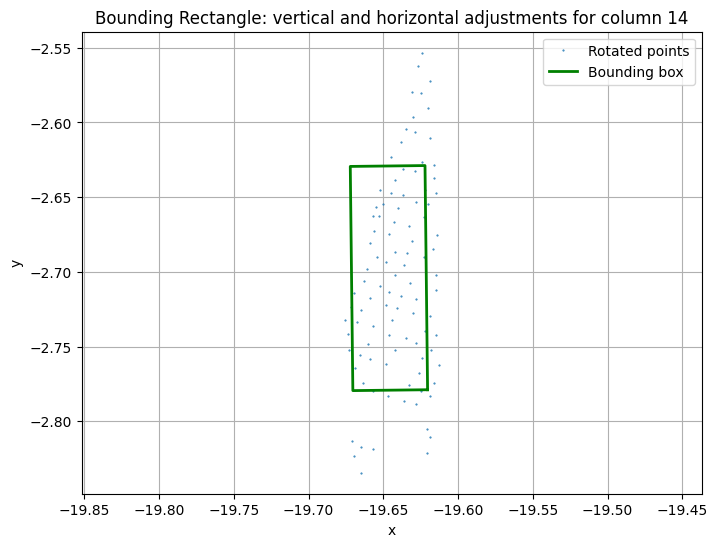

Column: 14, Width: 0.1581138830084187 Depth: 0.1581138830084189 Heigth: 0.051000000000000156 loc: [-19.64627601  -2.70413606   0.        ] rotation -0.6585431775644097


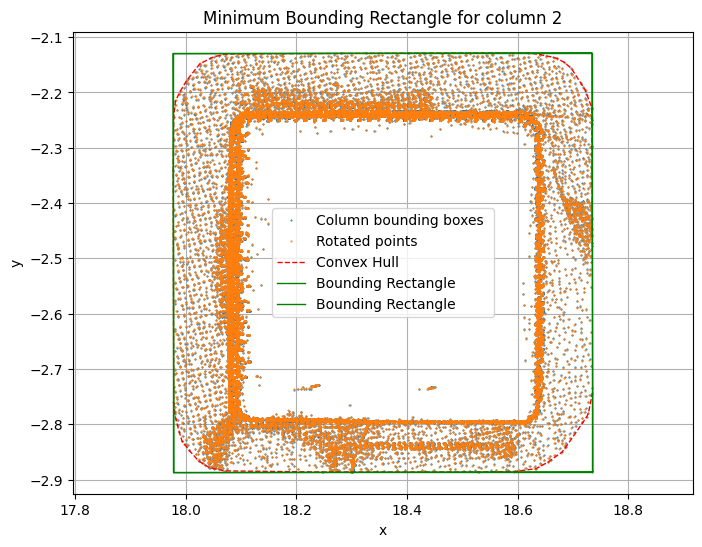

{'AB': (array([18.735118  , -2.88677198]), array([17.97744396, -2.88677198])), 'BC': (array([17.97744396, -2.88677198]), array([17.97744396, -2.12898603])), 'CD': (array([17.97744396, -2.12898603]), array([18.735118  , -2.12898603])), 'DA': (array([18.735118  , -2.12898603]), array([18.735118  , -2.88677198]))}
Middle points of each segment (in a list):
Segment name: AB, Point name: (18.35628097957863, -2.886771980432515), Middle points: (18.35628097957863, -2.886771980432515)
Segment name: BC, Point name: (17.9774439581401, -2.5078790067716215), Middle points: (17.9774439581401, -2.5078790067716215)
Segment name: CD, Point name: (18.35628097957863, -2.1289860331107278), Middle points: (18.35628097957863, -2.1289860331107278)
Segment name: DA, Point name: (18.735118001017163, -2.507879006771621), Middle points: (18.735118001017163, -2.507879006771621)
Coordinates assigned to points A1, B1, C1, D1:
A1: (18.35628097957863, -2.886771980432515)
B1: (17.9774439581401, -2.5078790067716215)
C

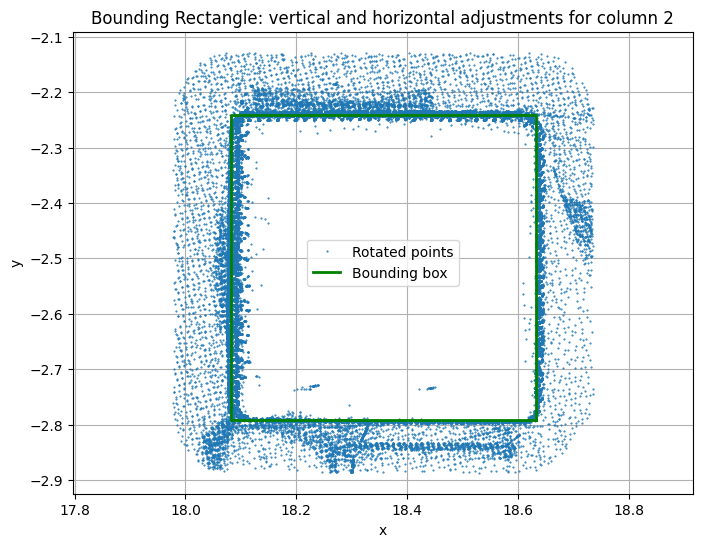

BBox_: [[18.63244396 -2.79177198]
 [18.08244396 -2.79177198]
 [18.08244396 -2.24177198]
 [18.63244396 -2.24177198]]
Center: [18.35628098 -2.50787901]
BBox:  [[18.63311911 -2.79111365]
 [18.08312067 -2.79242317]
 [18.08181115 -2.24242473]
 [18.63180959 -2.24111521]]


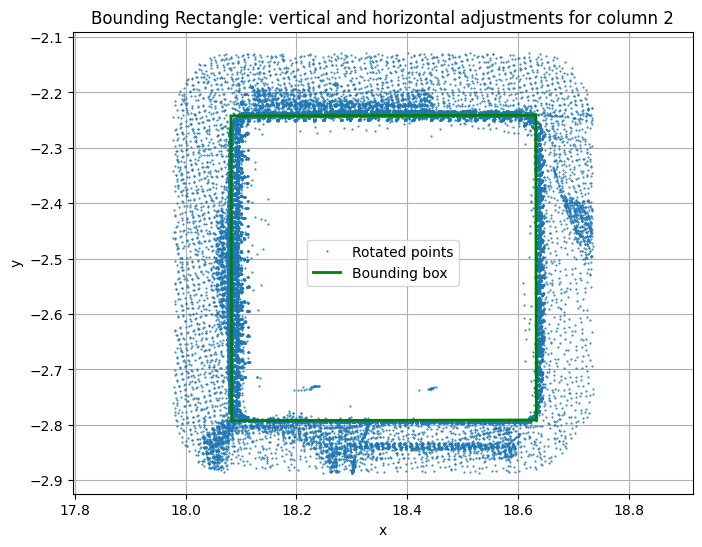

Column: 2, Width: 0.7778174593052545 Depth: 0.7778174593052548 Heigth: 2.752 loc: [18.35746513 -2.51676919  0.        ] rotation -0.13641826486820702


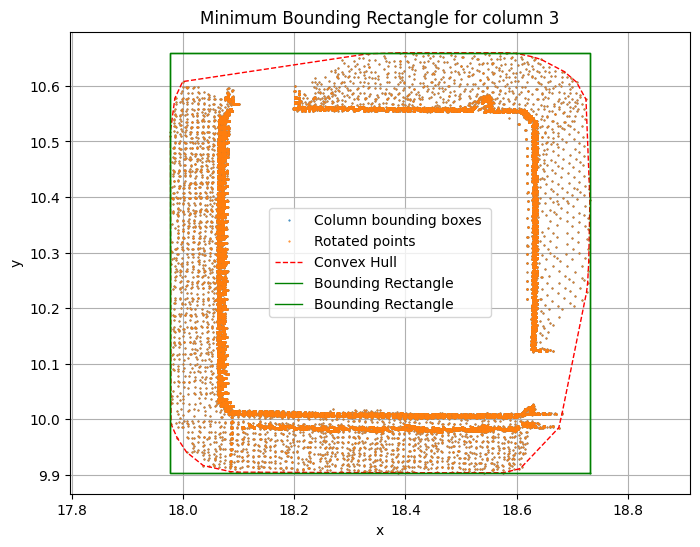

{'AB': (array([18.73204641,  9.90364067]), array([17.97704641,  9.90364067])), 'BC': (array([17.97704641,  9.90364067]), array([17.97704641, 10.65964067])), 'CD': (array([17.97704641, 10.65964067]), array([18.73204641, 10.65964067])), 'DA': (array([18.73204641, 10.65964067]), array([18.73204641,  9.90364067]))}
Middle points of each segment (in a list):
Segment name: AB, Point name: (18.35454640891293, 9.903640672822032), Middle points: (18.35454640891293, 9.903640672822032)
Segment name: BC, Point name: (17.977046408912933, 10.281640672822032), Middle points: (17.977046408912933, 10.281640672822032)
Segment name: CD, Point name: (18.35454640891293, 10.659640672822032), Middle points: (18.35454640891293, 10.659640672822032)
Segment name: DA, Point name: (18.73204640891293, 10.281640672822032), Middle points: (18.73204640891293, 10.281640672822032)
Coordinates assigned to points A1, B1, C1, D1:
A1: (18.35454640891293, 9.903640672822032)
B1: (17.977046408912933, 10.281640672822032)
C1: (

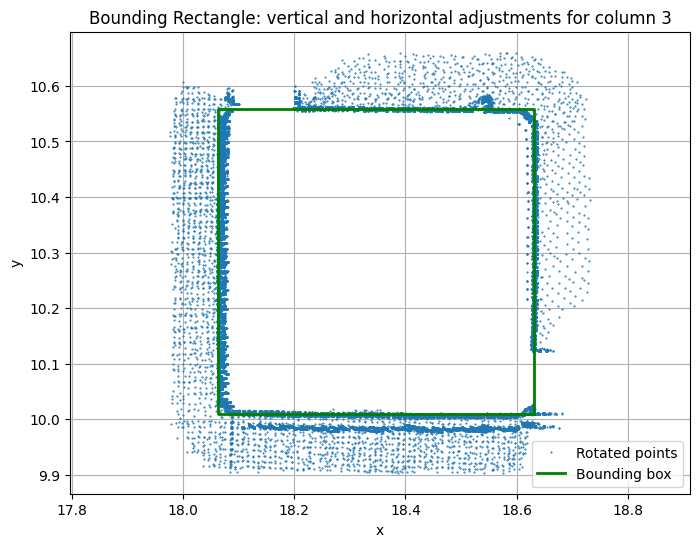

BBox_: [[18.63204641 10.00864067]
 [18.06204641 10.00864067]
 [18.06204641 10.55864067]
 [18.63204641 10.55864067]]
Center: [18.35454641 10.28164067]
BBox:  [[18.63204641 10.00864067]
 [18.06204641 10.00864067]
 [18.06204641 10.55864067]
 [18.63204641 10.55864067]]


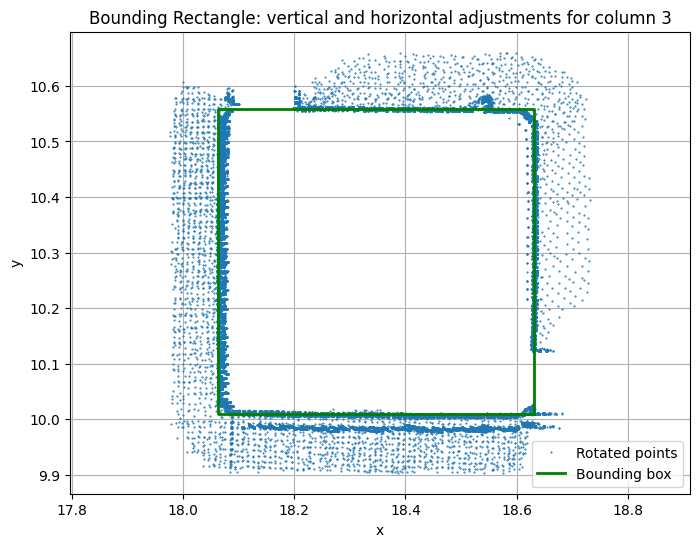

Column: 3, Width: 0.79208585393257 Depth: 0.79208585393257 Heigth: 2.7640000000000002 loc: [18.34704641 10.28364067  0.        ] rotation 3.508354649267438e-15


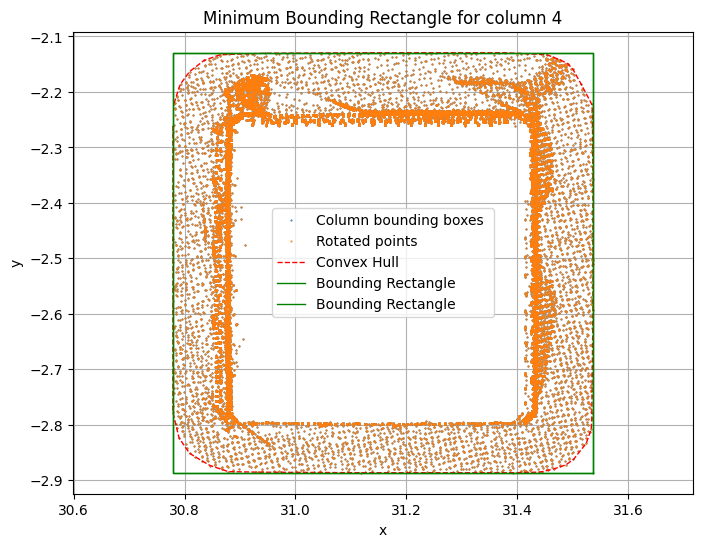

{'AB': (array([31.53604641, -2.88635933]), array([30.77904641, -2.88635933])), 'BC': (array([30.77904641, -2.88635933]), array([30.77904641, -2.12935933])), 'CD': (array([30.77904641, -2.12935933]), array([31.53604641, -2.12935933])), 'DA': (array([31.53604641, -2.12935933]), array([31.53604641, -2.88635933]))}
Middle points of each segment (in a list):
Segment name: AB, Point name: (31.157546408912932, -2.886359327177968), Middle points: (31.157546408912932, -2.886359327177968)
Segment name: BC, Point name: (30.779046408912933, -2.507859327177968), Middle points: (30.779046408912933, -2.507859327177968)
Segment name: CD, Point name: (31.157546408912932, -2.1293593271779683), Middle points: (31.157546408912932, -2.1293593271779683)
Segment name: DA, Point name: (31.53604640891293, -2.507859327177968), Middle points: (31.53604640891293, -2.507859327177968)
Coordinates assigned to points A1, B1, C1, D1:
A1: (31.157546408912932, -2.886359327177968)
B1: (30.779046408912933, -2.507859327177

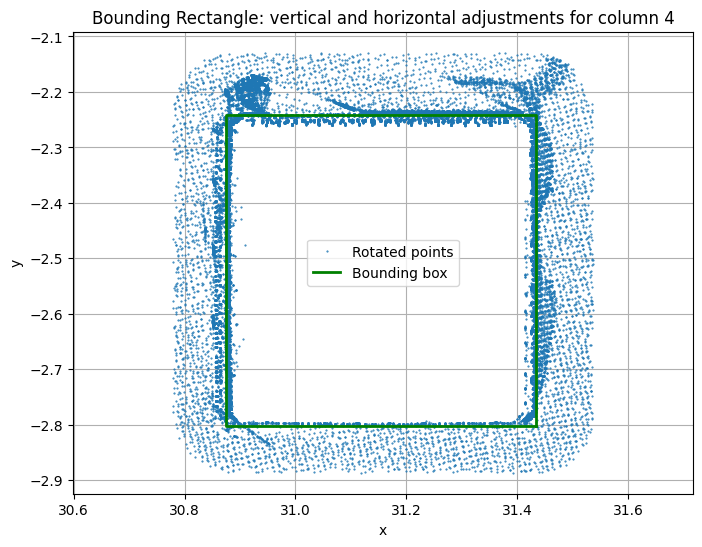

BBox_: [[31.43404641 -2.80135933]
 [30.87404641 -2.80135933]
 [30.87404641 -2.24135933]
 [31.43404641 -2.24135933]]
Center: [31.15754641 -2.50785933]
BBox:  [[31.43404641 -2.80135933]
 [30.87404641 -2.80135933]
 [30.87404641 -2.24135933]
 [31.43404641 -2.24135933]]


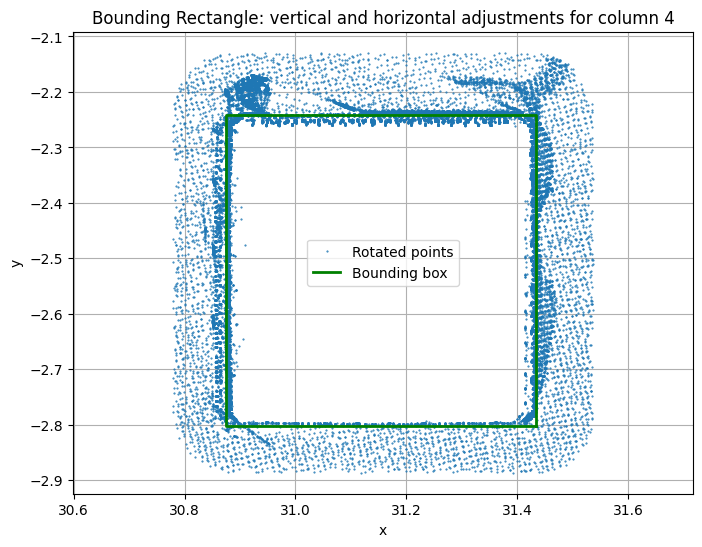

Column: 4, Width: 0.7919595949289866 Depth: 0.7919595949289866 Heigth: 2.769 loc: [31.15404641 -2.52135933  0.        ] rotation 3.508354649267438e-15


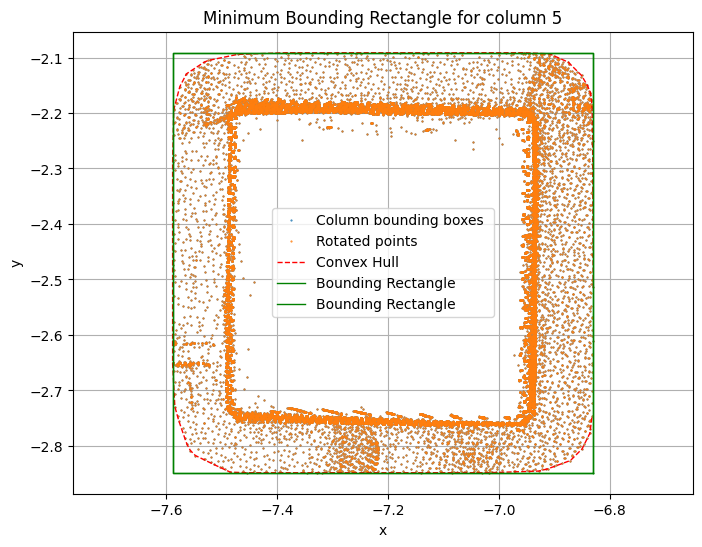

{'AB': (array([-6.82995359, -2.84835933]), array([-7.58795359, -2.84835933])), 'BC': (array([-7.58795359, -2.84835933]), array([-7.58795359, -2.09135933])), 'CD': (array([-7.58795359, -2.09135933]), array([-6.82995359, -2.09135933])), 'DA': (array([-6.82995359, -2.09135933]), array([-6.82995359, -2.84835933]))}
Middle points of each segment (in a list):
Segment name: AB, Point name: (-7.20895359108707, -2.848359327177973), Middle points: (-7.20895359108707, -2.848359327177973)
Segment name: BC, Point name: (-7.5879535910870715, -2.4698593271779727), Middle points: (-7.5879535910870715, -2.4698593271779727)
Segment name: CD, Point name: (-7.20895359108707, -2.0913593271779725), Middle points: (-7.20895359108707, -2.0913593271779725)
Segment name: DA, Point name: (-6.829953591087069, -2.4698593271779727), Middle points: (-6.829953591087069, -2.4698593271779727)
Coordinates assigned to points A1, B1, C1, D1:
A1: (-7.20895359108707, -2.848359327177973)
B1: (-7.5879535910870715, -2.46985932

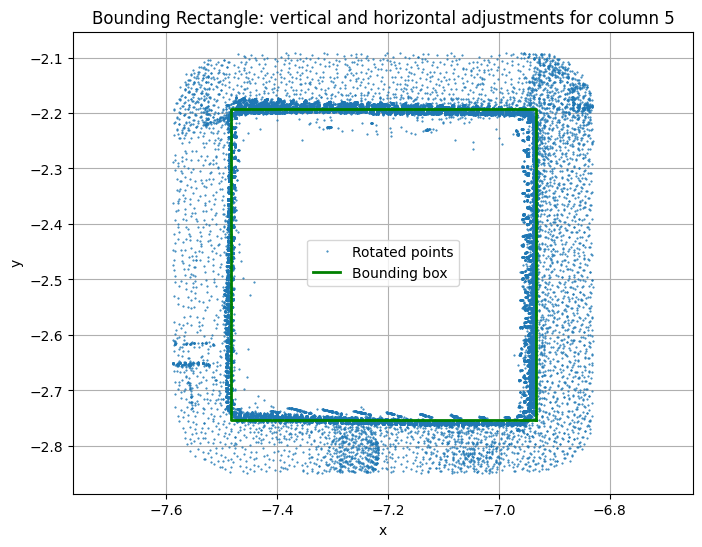

BBox_: [[-6.93295359 -2.75335933]
 [-7.48295359 -2.75335933]
 [-7.48295359 -2.19335933]
 [-6.93295359 -2.19335933]]
Center: [-7.20895359 -2.46985933]
BBox:  [[-6.93295359 -2.75335933]
 [-7.48295359 -2.75335933]
 [-7.48295359 -2.19335933]
 [-6.93295359 -2.19335933]]


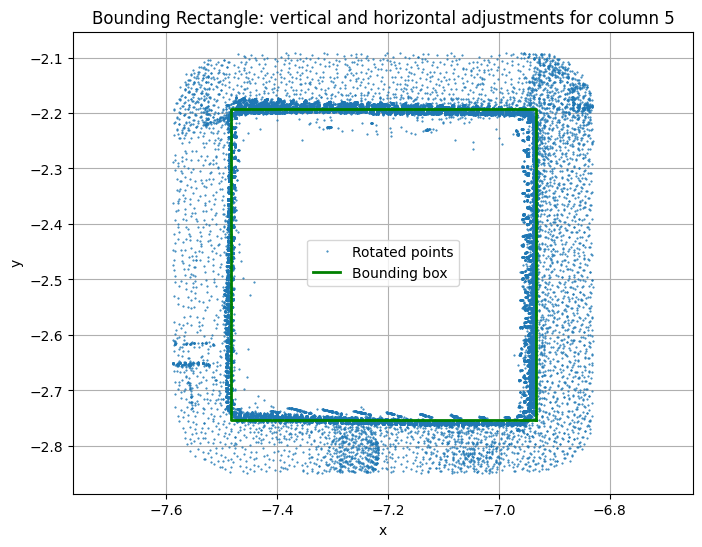

Column: 5, Width: 0.7849203781275994 Depth: 0.7849203781275994 Heigth: 2.771 loc: [-7.20795359 -2.47335933  0.        ] rotation 3.508354649267438e-15


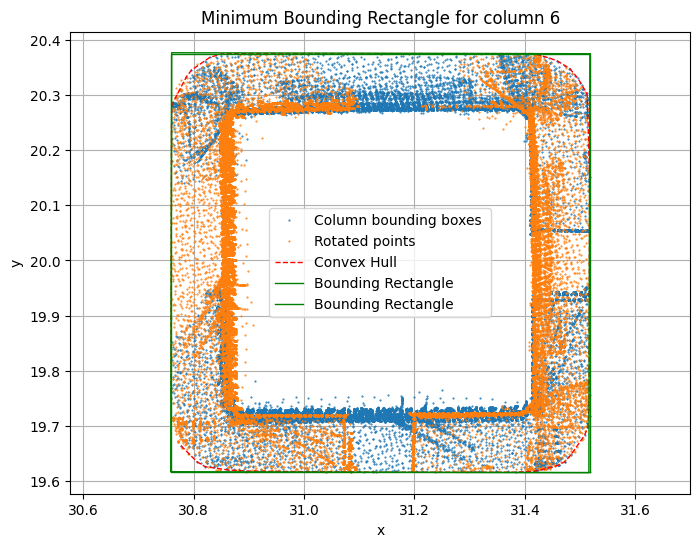

{'AB': (array([31.51740252, 19.61734374]), array([30.75869187, 19.61734374])), 'BC': (array([30.75869187, 19.61734374]), array([30.75869187, 20.37458237])), 'CD': (array([30.75869187, 20.37458237]), array([31.51740252, 20.37458237])), 'DA': (array([31.51740252, 20.37458237]), array([31.51740252, 19.61734374]))}
Middle points of each segment (in a list):
Segment name: AB, Point name: (31.138047193298622, 19.617343738083274), Middle points: (31.138047193298622, 19.617343738083274)
Segment name: BC, Point name: (30.758691868486324, 19.995963055341768), Middle points: (30.758691868486324, 19.995963055341768)
Segment name: CD, Point name: (31.138047193298622, 20.374582372600262), Middle points: (31.138047193298622, 20.374582372600262)
Segment name: DA, Point name: (31.51740251811092, 19.995963055341768), Middle points: (31.51740251811092, 19.995963055341768)
Coordinates assigned to points A1, B1, C1, D1:
A1: (31.138047193298622, 19.617343738083274)
B1: (30.758691868486324, 19.99596305534176

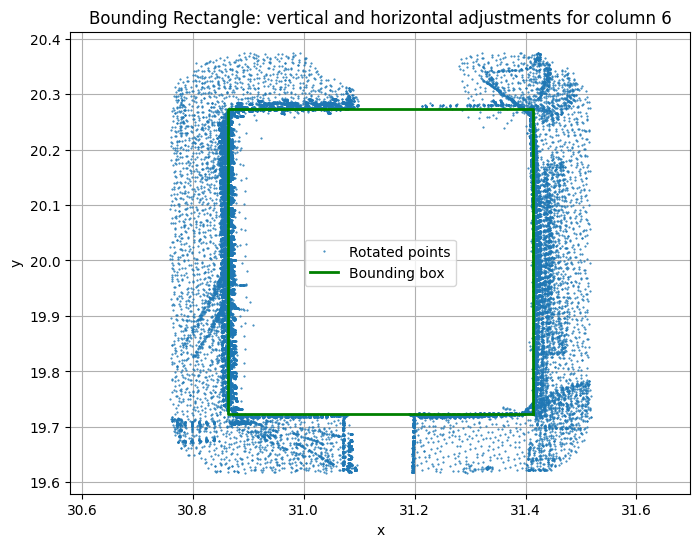

BBox_: [[31.41369187 19.72234374]
 [30.86369187 19.72234374]
 [30.86369187 20.27234374]
 [31.41369187 20.27234374]]
Center: [31.13804719 19.99596306]
BBox:  [[31.41233637 20.27094118]
 [31.41099817 19.7209428 ]
 [30.8609998  19.722281  ]
 [30.86233799 20.27227937]]


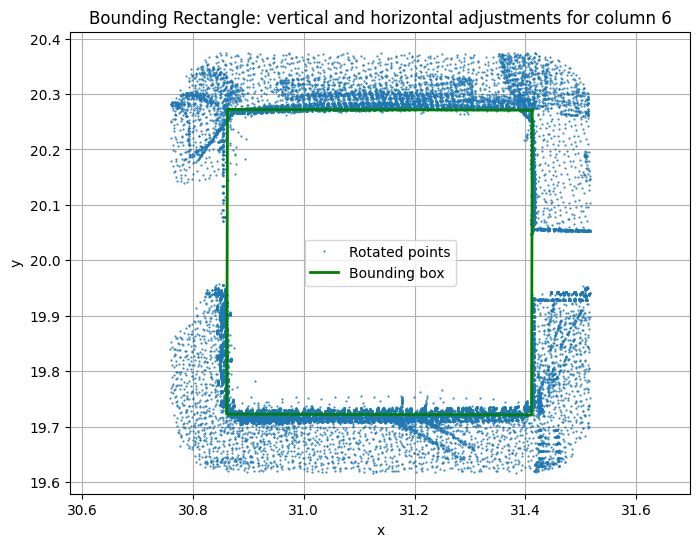

Column: 6, Width: 0.7778174593053218 Depth: 0.7778174593053218 Heigth: 2.751999999999999 loc: [31.13666808 19.99661109  0.        ] rotation -89.86059448552051


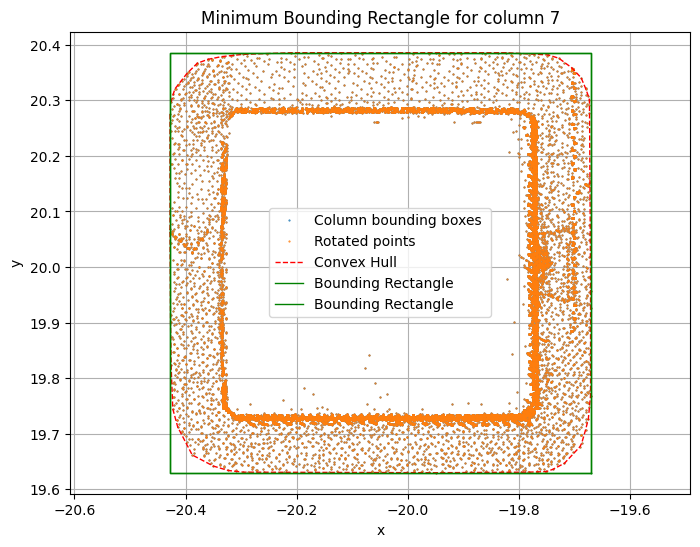

{'AB': (array([-19.67095359,  19.62964067]), array([-20.42795359,  19.62964067])), 'BC': (array([-20.42795359,  19.62964067]), array([-20.42795359,  20.38564067])), 'CD': (array([-20.42795359,  20.38564067]), array([-19.67095359,  20.38564067])), 'DA': (array([-19.67095359,  20.38564067]), array([-19.67095359,  19.62964067]))}
Middle points of each segment (in a list):
Segment name: AB, Point name: (-20.049453591087072, 19.629640672822028), Middle points: (-20.049453591087072, 19.629640672822028)
Segment name: BC, Point name: (-20.42795359108707, 20.007640672822028), Middle points: (-20.42795359108707, 20.007640672822028)
Segment name: CD, Point name: (-20.049453591087072, 20.385640672822028), Middle points: (-20.049453591087072, 20.385640672822028)
Segment name: DA, Point name: (-19.67095359108707, 20.007640672822028), Middle points: (-19.67095359108707, 20.007640672822028)
Coordinates assigned to points A1, B1, C1, D1:
A1: (-20.049453591087072, 19.629640672822028)
B1: (-20.4279535910

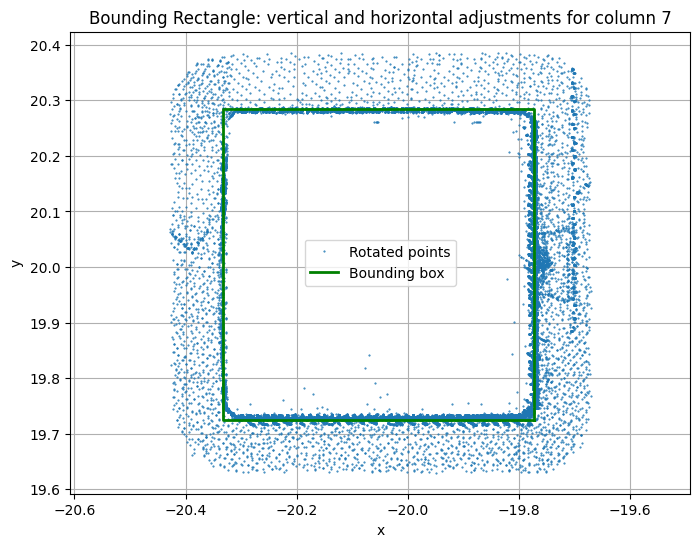

BBox_: [[-19.77295359  19.72464067]
 [-20.33295359  19.72464067]
 [-20.33295359  20.28464067]
 [-19.77295359  20.28464067]]
Center: [-20.04945359  20.00764067]
BBox:  [[-19.77295359  19.72464067]
 [-20.33295359  19.72464067]
 [-20.33295359  20.28464067]
 [-19.77295359  20.28464067]]


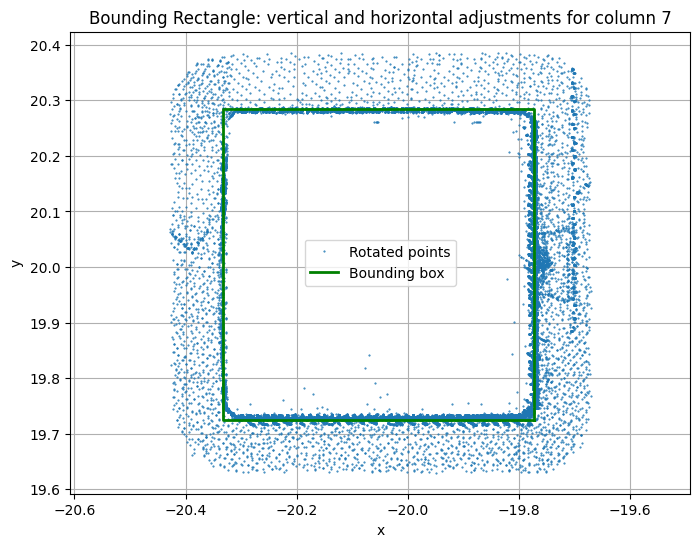

Column: 7, Width: 0.791959594929057 Depth: 0.791959594929057 Heigth: 2.753 loc: [-20.05295359  20.00464067   0.        ] rotation 3.508354649267438e-15


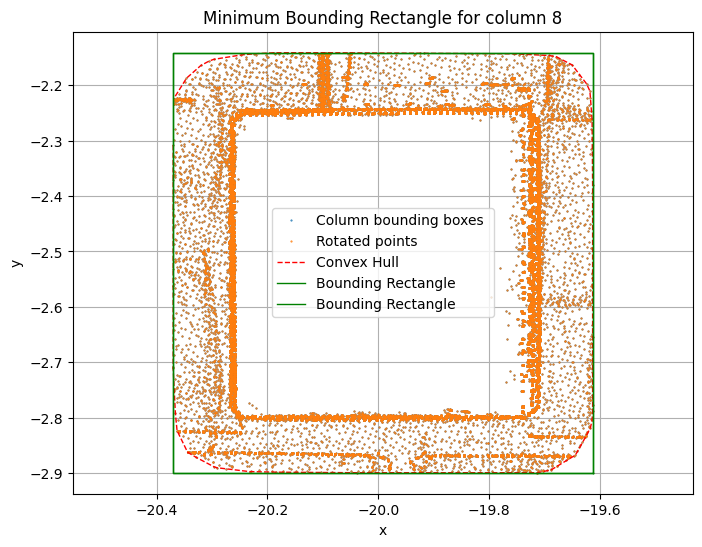

{'AB': (array([-19.61295359,  -2.89935933]), array([-20.36995359,  -2.89935933])), 'BC': (array([-20.36995359,  -2.89935933]), array([-20.36995359,  -2.14135933])), 'CD': (array([-20.36995359,  -2.14135933]), array([-19.61295359,  -2.14135933])), 'DA': (array([-19.61295359,  -2.14135933]), array([-19.61295359,  -2.89935933]))}
Middle points of each segment (in a list):
Segment name: AB, Point name: (-19.991453591087073, -2.899359327177974), Middle points: (-19.991453591087073, -2.899359327177974)
Segment name: BC, Point name: (-20.36995359108707, -2.520359327177974), Middle points: (-20.36995359108707, -2.520359327177974)
Segment name: CD, Point name: (-19.991453591087073, -2.141359327177974), Middle points: (-19.991453591087073, -2.141359327177974)
Segment name: DA, Point name: (-19.61295359108707, -2.520359327177974), Middle points: (-19.61295359108707, -2.520359327177974)
Coordinates assigned to points A1, B1, C1, D1:
A1: (-19.991453591087073, -2.899359327177974)
B1: (-20.3699535910

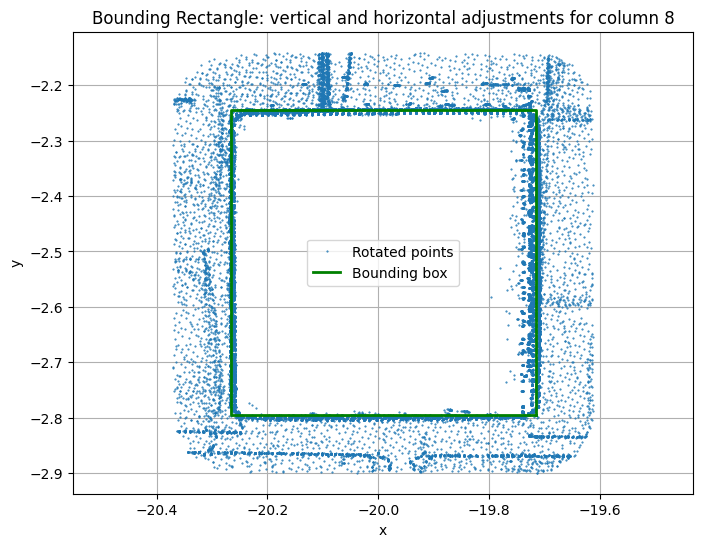

BBox_: [[-19.71495359  -2.79435933]
 [-20.26495359  -2.79435933]
 [-20.26495359  -2.24435933]
 [-19.71495359  -2.24435933]]
Center: [-19.99145359  -2.52035933]
BBox:  [[-19.71495359  -2.79435933]
 [-20.26495359  -2.79435933]
 [-20.26495359  -2.24435933]
 [-19.71495359  -2.24435933]]


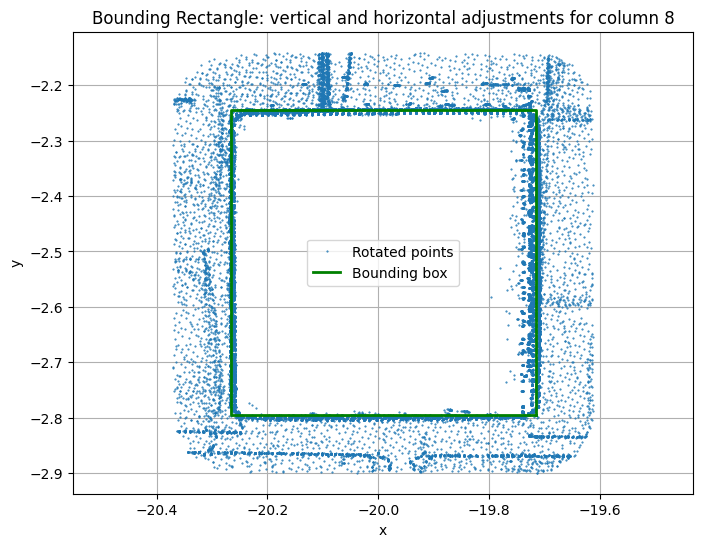

Column: 8, Width: 0.7778174593052548 Depth: 0.7778174593052548 Heigth: 2.7220000000000004 loc: [-19.98995359  -2.51935933   0.        ] rotation 3.508354649267438e-15


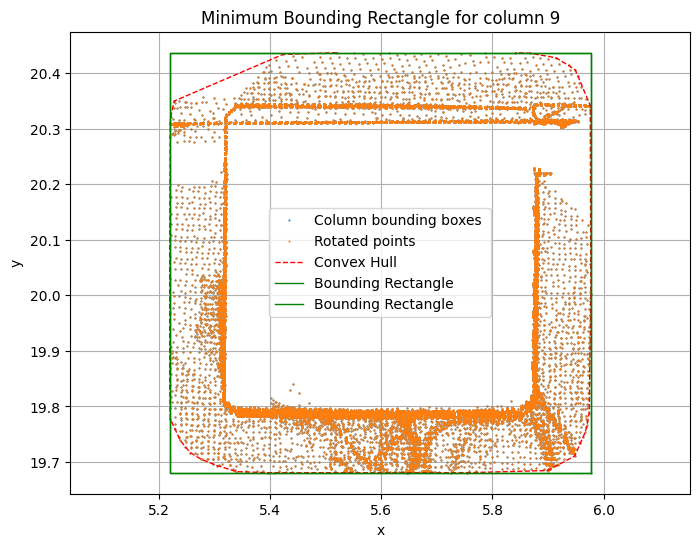

{'AB': (array([ 5.97704641, 19.68064067]), array([ 5.21904641, 19.68064067])), 'BC': (array([ 5.21904641, 19.68064067]), array([ 5.21904641, 20.43664067])), 'CD': (array([ 5.21904641, 20.43664067]), array([ 5.97704641, 20.43664067])), 'DA': (array([ 5.97704641, 20.43664067]), array([ 5.97704641, 19.68064067]))}
Middle points of each segment (in a list):
Segment name: AB, Point name: (5.59804640891293, 19.68064067282203), Middle points: (5.59804640891293, 19.68064067282203)
Segment name: BC, Point name: (5.2190464089129325, 20.05864067282203), Middle points: (5.2190464089129325, 20.05864067282203)
Segment name: CD, Point name: (5.59804640891293, 20.43664067282203), Middle points: (5.59804640891293, 20.43664067282203)
Segment name: DA, Point name: (5.977046408912928, 20.05864067282203), Middle points: (5.977046408912928, 20.05864067282203)
Coordinates assigned to points A1, B1, C1, D1:
A1: (5.59804640891293, 19.68064067282203)
B1: (5.2190464089129325, 20.05864067282203)
C1: (5.5980464089

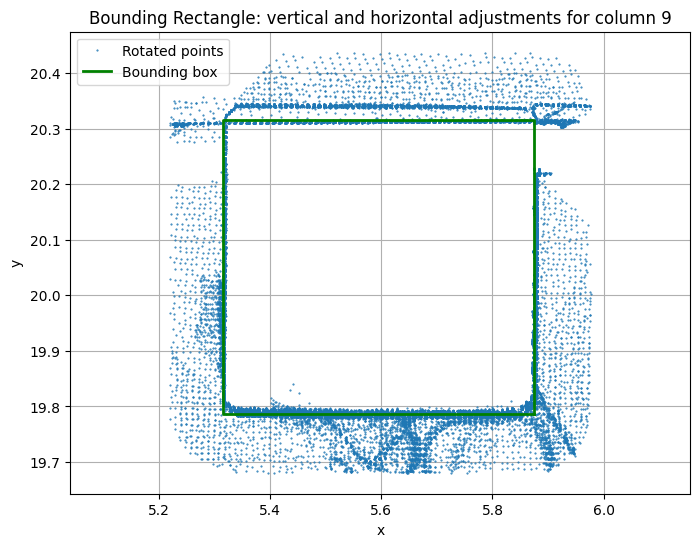

BBox_: [[ 5.87404641 19.78564067]
 [ 5.31404641 19.78564067]
 [ 5.31404641 20.31564067]
 [ 5.87404641 20.31564067]]
Center: [ 5.59804641 20.05864067]
BBox:  [[ 5.87404641 19.78564067]
 [ 5.31404641 19.78564067]
 [ 5.31404641 20.31564067]
 [ 5.87404641 20.31564067]]


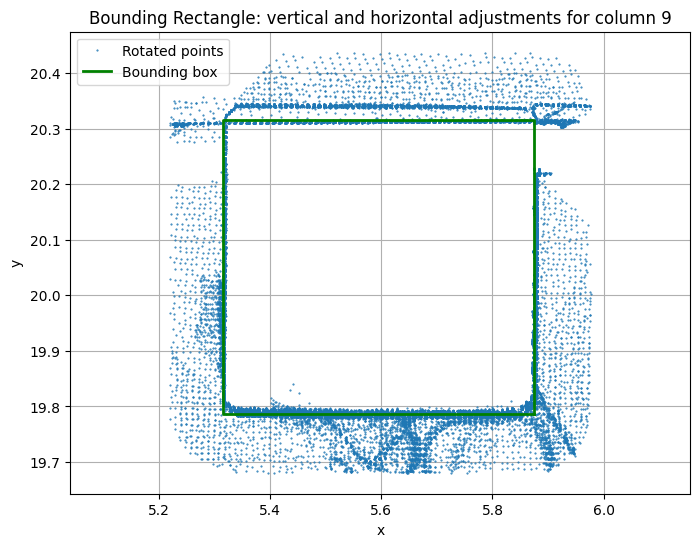

Column: 9, Width: 0.7710382610480977 Depth: 0.7710382610480977 Heigth: 2.7 loc: [ 5.59404641 20.05064067  0.        ] rotation 3.508354649267438e-15


In [7]:
plot = True

with open(output_file_path, "w") as output_file:

    for key in columns_points_2d:

        points = np.array(columns_points_2d[key][:, :2])

        bounding_box, rotation_matrix = compute_bounding_box(points)
        center = np.mean(bounding_box, axis=0)

        # Rotate bounding box vertices
        rotated_box = rotate_points(bounding_box, center, rotation_matrix.T)

        # Rotate all the points
        rotated_points = rotate_points(points, center, rotation_matrix.T)

        if plot:
            # Plotting
            plt.figure(figsize=(8, 6))
            plt.plot(points[:, 0], points[:, 1], 'o', markersize= 0.50, label='Column bounding boxes ')
            plt.plot(rotated_points[:, 0], rotated_points[:, 1], 'o', markersize= 0.50, label='Rotated points ')
            plt.plot(points[ConvexHull(points).vertices,0], points[ConvexHull(points).vertices,1], 'r--', lw=1, label='Convex Hull')
            plt.plot(np.append(bounding_box[:, 0], bounding_box[0, 0]), np.append(bounding_box[:, 1], bounding_box[0, 1]), 'g-', lw=1, label='Bounding Rectangle')
            plt.plot(np.append(rotated_box[:, 0], rotated_box[0, 0]), np.append(rotated_box[:, 1], rotated_box[0, 1]), 'g-', lw=1, label='Bounding Rectangle')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(f'Minimum Bounding Rectangle for column {key}')
            plt.legend()
            plt.grid(True)
            plt.axis('equal')
            plt.show()

        # Number of segments to divide the length
        s = 3

        # Vertices
        A = rotated_box[0]
        B = rotated_box[1]
        C = rotated_box[2]
        D = rotated_box[3]

        # Define segments with names
        segments = {'AB': (A,B), 'BC': (B,C), 'CD': (C,D), 'DA': (D,A)}
        print(segments)

        # Middle points of each segment
        middle_points_list = []
        for segment_name, segment in segments.items():
            x_middle = (segment[0][0] + segment[1][0])/2
            y_middle = (segment[0][1] + segment[1][1]) / 2
            middle_points_list.append((x_middle, y_middle))

        print("Middle points of each segment (in a list):")
        for i, middle_point in enumerate(middle_points_list):
            segment_name = list(segments.keys())[i]
            print(f"Segment name: {segment_name}, Point name: {middle_point}, Middle points: {middle_point}")

        # Assign coordinates to points A1, B1, C1, D1 based on middle points
        A1 = middle_points_list[0]
        B1 = middle_points_list[1]
        C1 = middle_points_list[2]
        D1 = middle_points_list[3]

        print("Coordinates assigned to points A1, B1, C1, D1:")
        print(f"A1: {A1}")
        print(f"B1: {B1}")
        print(f"C1: {C1}")
        print(f"D1: {D1}")

        # Direction vectors
        horizontal_segment = (D1[0]-B1[0], D1[1]-B1[1])
        vertical_segment = (A1[0]-C1[0], A1[1]-C1[1])

        # Compute the magnitude of the sectors 
        magnitude_horizontal_segment = np.sqrt(horizontal_segment[0]**2 + horizontal_segment[1]**2)
        magnitude_vertical_segment = np.sqrt(vertical_segment[0]**2 + vertical_segment[1]**2)
        print(f'Width: {magnitude_horizontal_segment} Thickness: {magnitude_vertical_segment}')

        # PROCESSING POINTS_ HORIZONTAL DIRECTION

        # HISTOGRAM
        i = 0.010

        cases_h = np.arange(min([p[0] for p in rotated_points]), max([p[0] for p in rotated_points]), i)

        case_b = cases_h [: len(cases_h)//s]
        hist_b, case_b = np.histogram([p[0] for p in rotated_points], bins=case_b)

        if len(hist_b) == 0:
            print(f'Column: {key} - could not compute features')
            output_file.write(f'Column: {key} - could not compute features\n')
            continue

        case_d = cases_h [2*len(cases_h)//s:]
        hist_d, case_d =  np.histogram([p[0] for p in rotated_points], bins=case_d)

        if len(hist_d) == 0:
            print(f'Column: {key} - could not compute features')
            output_file.write(f'Column: {key} - could not compute features\n')
            continue

        max_index_case_b = np.argmax(hist_b)
        max_index_case_d = np.argmax(hist_d)

        print("case_b", case_b)
        print("case_d", case_d)
        coord_b = case_b[max_index_case_b] + i/2
        coord_d = case_d[max_index_case_d] + i/2

        print("Coordinate of maximum value in case_b along horizontal_segment:", coord_b)
        print("Coordinate of maximum value in case_d along horizontal_segment:", coord_d)
        B[0] = coord_b 
        C[0] = coord_b 
        A[0] = coord_d
        D[0] = coord_d

        # # New bbox
        new_points = np.array([A,B,C,D])
        print(new_points)
        print(rotated_points)

        # PROCESSING POINTS_ VERTICAL DIRECTION

        # HISTOGRAM
        i = 0.010

        cases_v = np.arange(min([p[1] for p in rotated_points]), max([p[1] for p in rotated_points]), i)

        case_a = cases_v [: len(cases_v)//s]
        hist_a, case_a = np.histogram([p[1] for p in rotated_points], bins=case_a)

        if len(hist_a) == 0:
            print(f'Column: {key} - could not compute features')
            output_file.write(f'Column: {key} - could not compute features\n')
            continue

        case_c = cases_v [2*len(cases_v)//s:]
        hist_c, case_c =  np.histogram([p[1] for p in rotated_points], bins=case_c)

        if len(hist_c) == 0:
            print(f'Column: {key} - could not compute features')
            output_file.write(f'Column: {key} - could not compute features\n')
            continue

        max_index_case_a = np.argmax(hist_a)
        max_index_case_c = np.argmax(hist_c)

        print("case_b", case_a)
        print("case_d", case_c)
        coord_a = case_a[max_index_case_a] + i/2
        coord_c = case_c[max_index_case_c] + i/2

        print("Coordinate of maximum value in case_b along horizontal_segment:", coord_a)
        print("Coordinate of maximum value in case_d along horizontal_segment:", coord_c)

        B[1] = coord_a 
        C[1] = coord_c 
        A[1] = coord_a
        D[1] = coord_c

        # # New bbox
        new_points = np.array([A,B,C,D])
        print("new_points", new_points)
        print(rotated_points)

        if plot:
            # Plotting
            plt.figure(figsize=(8, 6))
            plt.plot(rotated_points[:, 0], rotated_points[:, 1], 'o', markersize= 0.50, label='Rotated points')
            plt.plot(np.append(rotated_box[:, 0], rotated_box[0, 0]), np.append(rotated_box[:, 1], rotated_box[0, 1]), 'g-', lw=2, label='Bounding box')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(f'Bounding Rectangle: vertical and horizontal adjustments for column {key}')
            plt.legend()
            plt.grid(True)
            plt.axis('equal')
            plt.show()

        # Inputs
        print('BBox_:', rotated_box)
        print("Center:", center)

        minimum_oriented_box = rotate_points(rotated_box, center, rotation_matrix)
        print('BBox: ', minimum_oriented_box)
        # points = rotate_points (rotated_points, center, rotation_matrix )

        if plot:
            # Plotting
            plt.figure(figsize=(8, 6))
            plt.plot(points[:, 0], points[:, 1], 'o', markersize= 0.50, label='Rotated points')
            plt.plot(np.append(minimum_oriented_box[:, 0], minimum_oriented_box[0, 0]), np.append(minimum_oriented_box[:, 1], minimum_oriented_box[0, 1]), 'g-', lw=2, label='Bounding box')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(f'Bounding Rectangle: vertical and horizontal adjustments for column {key}')
            plt.legend()
            plt.grid(True)
            plt.axis('equal')
            plt.show()

        w, d, h, c, r = column_featrues(columns_points[key], minimum_oriented_box, rotation_matrix)
        
        print(f'Column: {key}, Width: {w} Depth: {d} Heigth: {h} loc: {c} rotation {r}')

        output_file.write(f'Column: {key}\n Width: {w:.3f}\n Depth: {d:.3f}\n Heigth: {h:.3f}\n loc: [{c[0]:.3f}, {c[1]:.3f}, {c[2]:.3f}]\n rotation {r:.3f}\n')